In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load data
data_train = pd.read_csv('D:/CWA/Kaggle/Titanic/train.csv')
data_test = pd.read_csv('D:/CWA/Kaggle/Titanic/test.csv')

# Display Sample
data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.5500,NaN,S
764,765,0,3,"Eklund, Mr. Hans Linus",male,16.0,0,0,347074,7.7750,NaN,S
455,456,1,3,"Jalsevac, Mr. Ivan",male,29.0,0,0,349240,7.8958,NaN,C


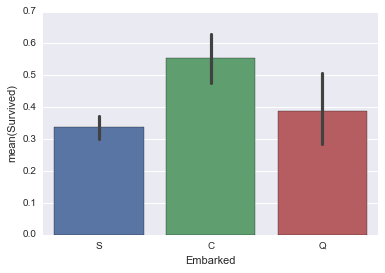

In [2]:
# Bar plot
sns.barplot(x="Embarked", y="Survived", data=data_train);

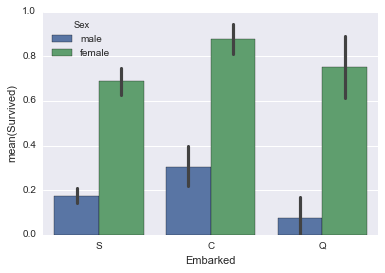

In [3]:
# Bar plot
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train);

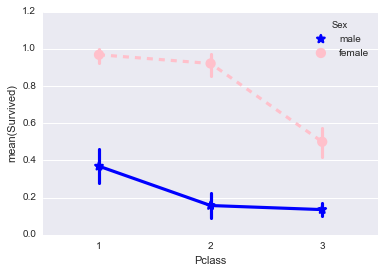

In [4]:
# Point plot
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

In [5]:
# Data transformation
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def impute_embarked(df):
    df.Embarked = df.Embarked.fillna('C')
    return df

def impute_SibSp(df):
    df.SibSp = df.SibSp + df.Parch + 1
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Parch'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = impute_embarked(df)
    df = impute_SibSp(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Fare,Cabin,Embarked,Lname,NamePrefix
0,1,0,3,male,Student,2,1_quartile,N,S,"Braund,",Mr.
1,2,1,1,female,Adult,2,4_quartile,C,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,1,1_quartile,N,S,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,2,4_quartile,C,S,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,1,2_quartile,N,S,"Allen,",Mr.


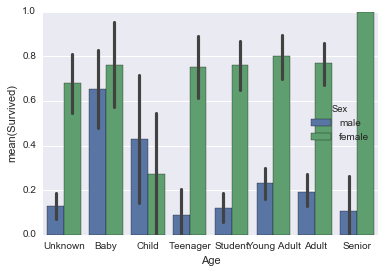

In [6]:
# Bar plot
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train);

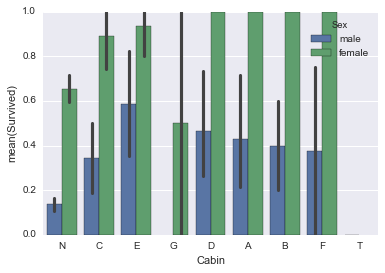

In [7]:
# Bar plot
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train);

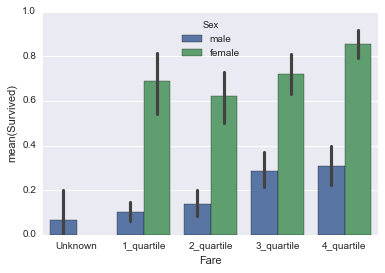

In [8]:
# Bar plot
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train);

In [9]:
# Feature encoding
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix', 'Embarked']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Fare,Cabin,Embarked,Lname,NamePrefix
0,1,0,3,1,4,2,0,7,2,100,19
1,2,1,1,0,0,2,3,2,0,182,20
2,3,1,3,0,7,1,0,7,2,329,16
3,4,1,1,0,7,2,3,2,2,267,20
4,5,0,3,1,7,1,1,7,2,15,19


In [10]:
# Split train & validation data
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.30
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

In [11]:
# Fitting & Tuning an algo
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=6, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [12]:
# Prediction on validation data
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.805970149254


In [13]:
# KFold cross-validation
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=5)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

Fold 1 accuracy: 0.8268156424581006
Fold 2 accuracy: 0.7808988764044944
Fold 3 accuracy: 0.8595505617977528
Fold 4 accuracy: 0.8089887640449438
Fold 5 accuracy: 0.8033707865168539
Mean Accuracy: 0.8159249262444291


D:\Users\703181031\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
# Predict the Actual Test Data
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
# output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
